In [ ]:
# For TensorFlow version 2.12 or earlier

# Command Line Tools
# sudo rm -rf /Library/Developer/CommandLineTools
# xcode-select --install

# Create conda environment
# conda create -n tensorenv python=3.10
# conda activate tensorenv

# And then Tensorflow dependencies
# conda install apple::tensorflow-deps
# conda install notebook -y

# pip install pandas matplotlib scikit-learn scipy plotly --upgrade
# pip install tensorflow-macos==2.12 numpy==1.23.5 tensorflow-metal==0.8.0 --force-reinstall

# WARNING:absl:At this time, the v2.11+ optimizer 
# `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, 
# please use the legacy Keras optimizer instead, 
# located at `tf.keras.optimizers.legacy.Adam`.

# WARNING:absl:There is a known slowdown when using v2.11+
#  Keras optimizers on M1/M2 Macs. 
# Falling back to the legacy Keras optimizer, i.e.,
#  `tf.keras.optimizers.legacy.Adam`.
# M



# TensorFlow 2.16.1
# To continue using Keras 2.0, do the following.
# Install  via pip install tf-keras~=2.16

# # To switch tf.keras to use Keras 2 (tf-keras), 
# set the environment variable TF_USE_LEGACY_KERAS=1 directly 
# or in your python program with 
# import os;os.environ["TF_USE_LEGACY_KERAS"]="1". 
# Please note that this will set it for all packages 
# in your Python runtime program

# # Change the keras import: 
# replace import tensorflow.keras as keras or 
# import keras with import tf_keras as keras. 
# Update any tf.keras references to keras.

# For TensorFlow version 2.13 or later
# pip install tensorflow 

In [ ]:
src_path = "../src/"
lib_path = "../lib/"
input_path = "../../kaggle/input/home-credit-default-risk/"

In [ ]:
import platform
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

pd.set_option("display.max_columns", 200)
tf.random.set_seed(42)
set_config(transform_output="pandas")

sys.path.insert(0, src_path)
data_processing = joblib.load(lib_path + "data_processing.joblib")
preprocessor = data_processing["preprocessor"]
non_co_cols = data_processing["non_co_cols"]
merged_application_test = data_processing["merged_application_train"]
from threshold_tuner import ClassificationThresholdTuner
del sys.path[0]

In [ ]:
def plot_history(history):
    for metric in history.history.keys():
        if not metric.startswith("val"):
            plt.plot(history.history[metric], label=metric)
            if f"val_{metric}" in history.history.keys():
                plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
            plt.title(metric)
            plt.legend()
            plt.show()

In [ ]:
print(f"{platform.platform()}")
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
print(f"SciPy {scipy.__version__}")
print()
print(f"TensorFlow {tf.__version__}")
print(f"Keras {keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
tf.config.list_physical_devices('GPU')

In [ ]:
# separate data
X = merged_application_test.drop(columns=["TARGET", "SK_ID_CURR"])
y = merged_application_test["TARGET"].copy()

In [ ]:
# split data 80/10/10 for training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=0.5, random_state=42)
# transform data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
X_train = X_train.drop(columns=non_co_cols)
X_val = X_val.drop(columns=non_co_cols)
X_test = X_test.drop(columns=non_co_cols)
# scale remaining data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
from keras.utils import to_categorical

# create y arrays for multiclass modeling
y_array_train = to_categorical(y_train)
y_array_val = to_categorical(y_val)
y_array_test = to_categorical(y_test)

In [ ]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
from keras.metrics import AUC
# from keras.optimizers.legacy import Adam


# Binary Classification Scenario 1
# --------------------------------
# If your model outputs a softmax vector (probabilities for each class),
# your target variable should be one-hot encoded.
# You can use tf.keras.utils.to_categorical to convert integer labels to one-hot vectors.
# array([[0., 1.],
#        [1., 0.],
#        [1., 0.],
#        ...,
#        [1., 0.],
#        [0., 1.],
#        [1., 0.]], dtype=float32)
# For multi-class classification with one-hot encoded targets (softmax activation), use categorical_crossentropy.
def create_model_1():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(4, activation="relu"))  # Hidden layer 1
    model.add(Dense(2, activation="softmax"))  # Output layer

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc")]
    )
    return model


model_1 = create_model_1()

history_1 = model_1.fit(X_train, y_array_train, validation_data=(X_val, y_array_val), epochs=50, batch_size=256)

In [ ]:
plot_history(history_1)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

y_array_pred = model_1.predict(X_test)
y_array_pred = np.argmax(y_array_pred, axis=1)
y_array_test = pd.DataFrame(y_array_test)

print(classification_report(y_array_test[1], y_array_pred, zero_division=np.nan))
ConfusionMatrixDisplay.from_predictions(y_array_test[1], y_array_pred);

In [ ]:
model_1.evaluate(X_test, y_test, batch_size=256)

In [ ]:
model_1.metrics_names

In [ ]:
# Binary Classification Scenario 2
# --------------------------------
# If you're doing binary classification, ensure your final layer
# has one neuron and uses a sigmoid activation function.
# 0         1
# 1         0
# 2         0
# 3         0
# 4         0
#          ..
# 307506    0
# 307507    0
# 307508    0
# 307509    1
# 307510    0
# Name: TARGET, Length: 307511, dtype: int64
# For binary classification with a single output neuron (sigmoid activation), use binary_crossentropy.
def create_model_2():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(64, activation="relu"))  # Hidden layer 1
    model.add(Dense(32, activation="relu"))  # Hidden layer 2
    model.add(Dense(16, activation="relu"))  # Hidden layer 3
    model.add(Dense(16, activation="relu"))  # Hidden layer 4
    model.add(Dense(1, activation="sigmoid"))  # Output layer

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", AUC(name="auc")],
    )
    return model


model_2 = create_model_2()
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


In [ ]:
plot_history(history_2)

In [ ]:
model_2.evaluate(X_test, y_test, batch_size=256)

In [100]:
preds = model_2.predict(X_test)
preds

961/961 [==============================] - 2s 2ms/step


array([[0.12445392],
       [0.05695505],
       [0.08119449],
       ...,
       [0.21243966],
       [0.16997203],
       [0.7350089 ]], dtype=float32)

In [101]:
y_pred = pd.DataFrame(
    {"zero": 0, "pred": np.nan}, index=range(len(preds))
)

for i in range(len(preds)):
    y_pred.iloc[i, 1] = preds[i][0]

y_pred

,zero,pred
0,0,0.124454
1,0,0.056955
2,0,0.081194
3,0,0.046181
4,0,0.117804
...,...,...
30747,0,0.233229
30748,0,0.089825
30749,0,0.212440
30750,0,0.169972


In [102]:
# y_pred = (y_pred>0.25) # It will evaluate the logical expression y_pred>0.25 and return True or False 
model_2_pred = pd.DataFrame(columns=["Pred"], index=y_test.index)
model_2_pred['Pred'] = np.where(y_pred > 0.50, 1, 0)

model_2_pred.tail(10)


,Pred
280076,0
288818,0
228578,0
16278,0
29823,0
68298,0
34458,0
1730,0
61780,0
65706,0


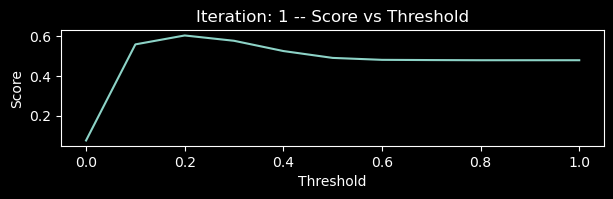

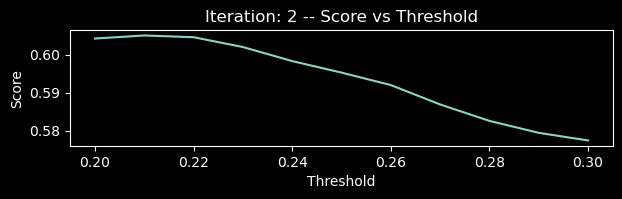

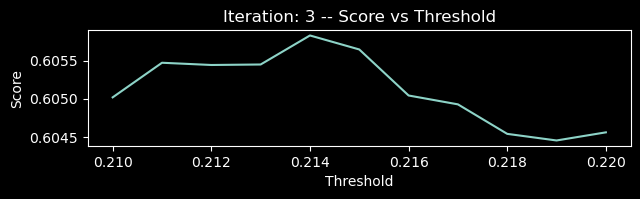

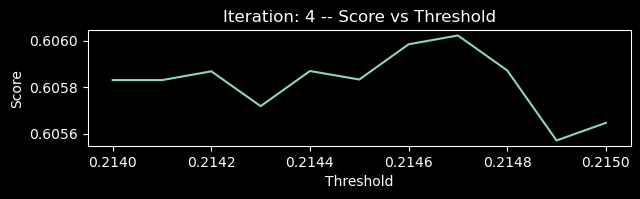

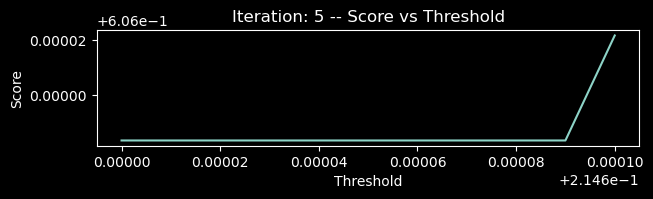

/Users/bharat/Documents/GitHub/neural-home-credit-default-risk/kaggle/working/../src/threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,0,1,Macro
0,Precision,0.920896,0.422535,0.671715
0,Recall,0.998551,0.012210,0.505380
0,F1,0.958152,0.023734,0.490943


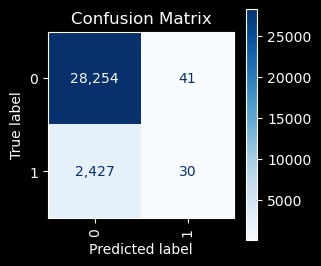

,Metric,Score
0,Brier Score,0.068497
1,AUROC,0.740805


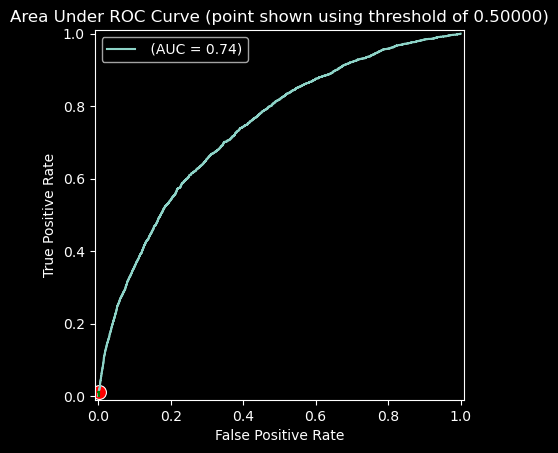

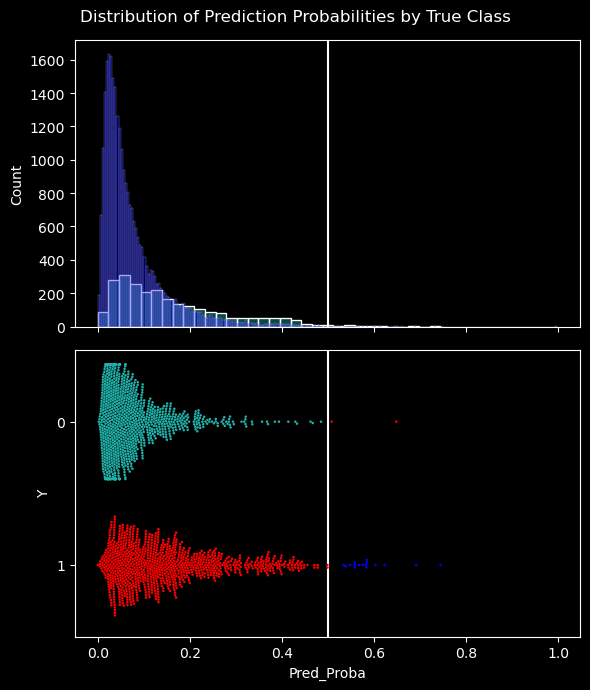

In [103]:
tuner_2 = ClassificationThresholdTuner()


from sklearn.metrics import f1_score

best_threshold_2 = tuner_2.tune_threshold(
    y_true=y_test, 
    target_classes=[0,1],
    y_pred_proba=y_pred,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)

tuner_2.print_stats_proba(
    y_true=y_test, 
    target_classes=[0,1], 
    y_pred_proba=y_pred) 


tuned_pred_2 = tuner_2.get_predictions(
    target_classes=[0, 1],
    y_pred_proba=y_pred,
    default_class=0,
    thresholds=best_threshold_2,
)
tuned_pred_2 = pd.Series(tuned_pred_2)
tuned_pred_2 = tuned_pred_2.astype(int)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     28295
           1       0.28      0.27      0.27      2457

    accuracy                           0.89     30752
   macro avg       0.61      0.60      0.61     30752
weighted avg       0.88      0.89      0.89     30752



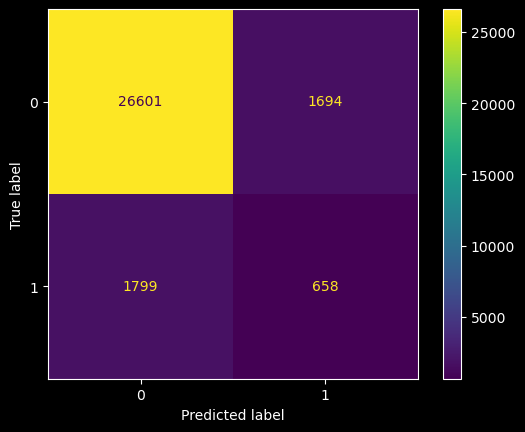

In [105]:
print(classification_report(y_true=y_test, y_pred=tuned_pred_2))
# print(classification_report(y_test, y_pred, zero_division=np.nan))
ConfusionMatrixDisplay.from_predictions(y_test, tuned_pred_2)
# ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test)

In [ ]:
# Binary Classification Scenario 3
# --------------------------------
# If your model outputs a single value (e.g., a probability between 0 and 1 for binary classification),
# your target variable should be a single value (0 or 1).
# If you're doing multi-class classification, ensure your final layer has a number of neurons equal to the number of classes
# and uses a softmax activation function. Also ensure that your labels are properly one-hot encoded.
# For multi-class classification with integer targets, use sparse_categorical_crossentropy.
def create_model_3():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(32, activation="relu"))  # Hidden layer 1
    model.add(Dense(16, activation="relu"))  # Hidden layer 2
    model.add(Dense(8, activation="relu"))  # Hidden layer 2
    model.add(Dense(y_train.nunique(), activation="softmax"))  # Output layer

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

model_3 = create_model_3()
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=256)

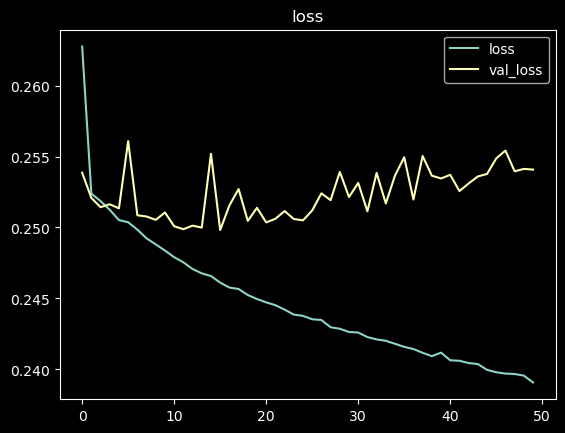

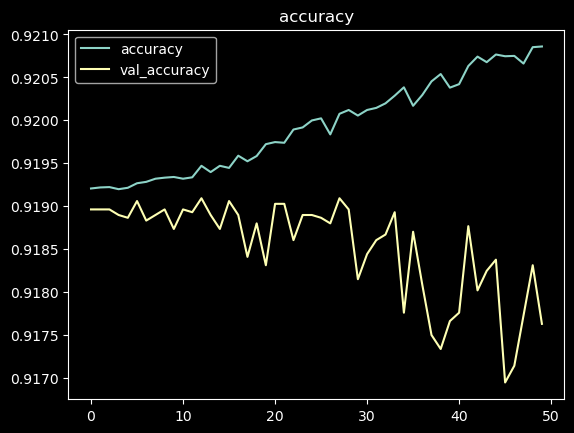

In [106]:
plot_history(history_3)

In [107]:
from sklearn.metrics import roc_auc_score

# Make predictions on the validation set
y_pred_proba = model_3.predict(X_test)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Assuming binary classification and probabilities for class 1

print(f"Validation AUC: {test_auc}")

961/961 [==============================] - 2s 2ms/step
Validation AUC: 0.7390819210045221


,Start Range %,End Range %,Min Probability,Max Probability,Count 0,Count 1,Total Count,Precision,Recall,Cumulative Count 1,Cumulative Total Count,Cumulative Precision,Cumulative Recall
0,0.999967,1.000000,9.854898e-01,9.854898e-01,1,0,1,0.0,0.000000,0,1,0.000000,0.000000
1,0.999935,0.999967,9.800497e-01,9.800497e-01,1,0,1,0.0,0.000000,0,2,0.000000,0.000000
2,0.999902,0.999935,9.769143e-01,9.769143e-01,1,0,1,0.0,0.000000,0,3,0.000000,0.000000
3,0.999870,0.999902,9.726509e-01,9.726509e-01,1,0,1,0.0,0.000000,0,4,0.000000,0.000000
4,0.999837,0.999870,9.418829e-01,9.418829e-01,1,0,1,0.0,0.000000,0,5,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30747,0.000130,0.000163,8.892885e-07,1.131748e-06,2,0,2,0.0,0.000000,2456,30748,0.079875,0.999593
30748,0.000098,0.000130,NaN,NaN,0,0,0,0.0,0.000000,2456,30748,0.079875,0.999593
30749,0.000065,0.000098,3.693877e-07,4.759589e-07,2,0,2,0.0,0.000000,2456,30750,0.079870,0.999593
30750,0.000033,0.000065,1.687723e-15,1.687723e-15,0,1,1,1.0,0.000407,2457,30751,0.079900,1.000000


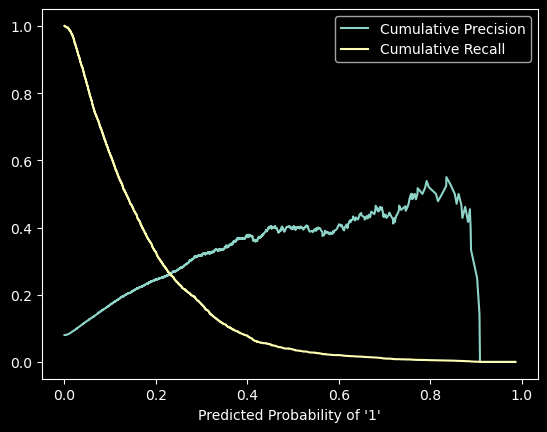

/Users/bharat/Documents/GitHub/neural-home-credit-default-risk/kaggle/working/../src/threshold_tuner.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  display_df = pd.concat([display_df, pd.DataFrame([['Precision'] + prec_arr.tolist()], columns=display_df.columns)])


,Metric,0,1,Macro
0,Precision,0.922482,0.395652,0.659067
0,Recall,0.995087,0.037037,0.516062
0,F1,0.957410,0.067734,0.512572


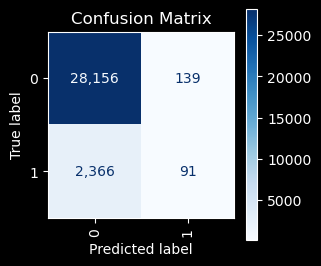

,Metric,Score
0,Brier Score,0.069278
1,AUROC,0.739082


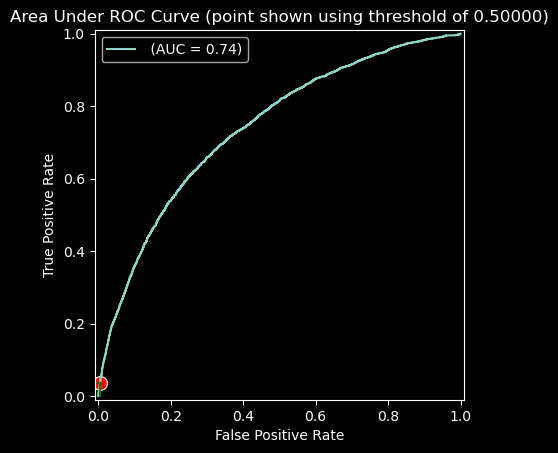

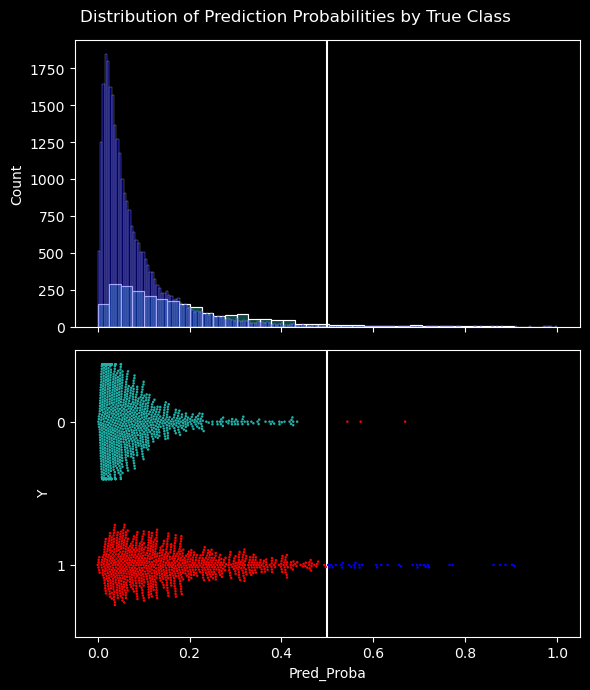

100%|██████████| 9/9 [00:48<00:00,  5.34s/it]


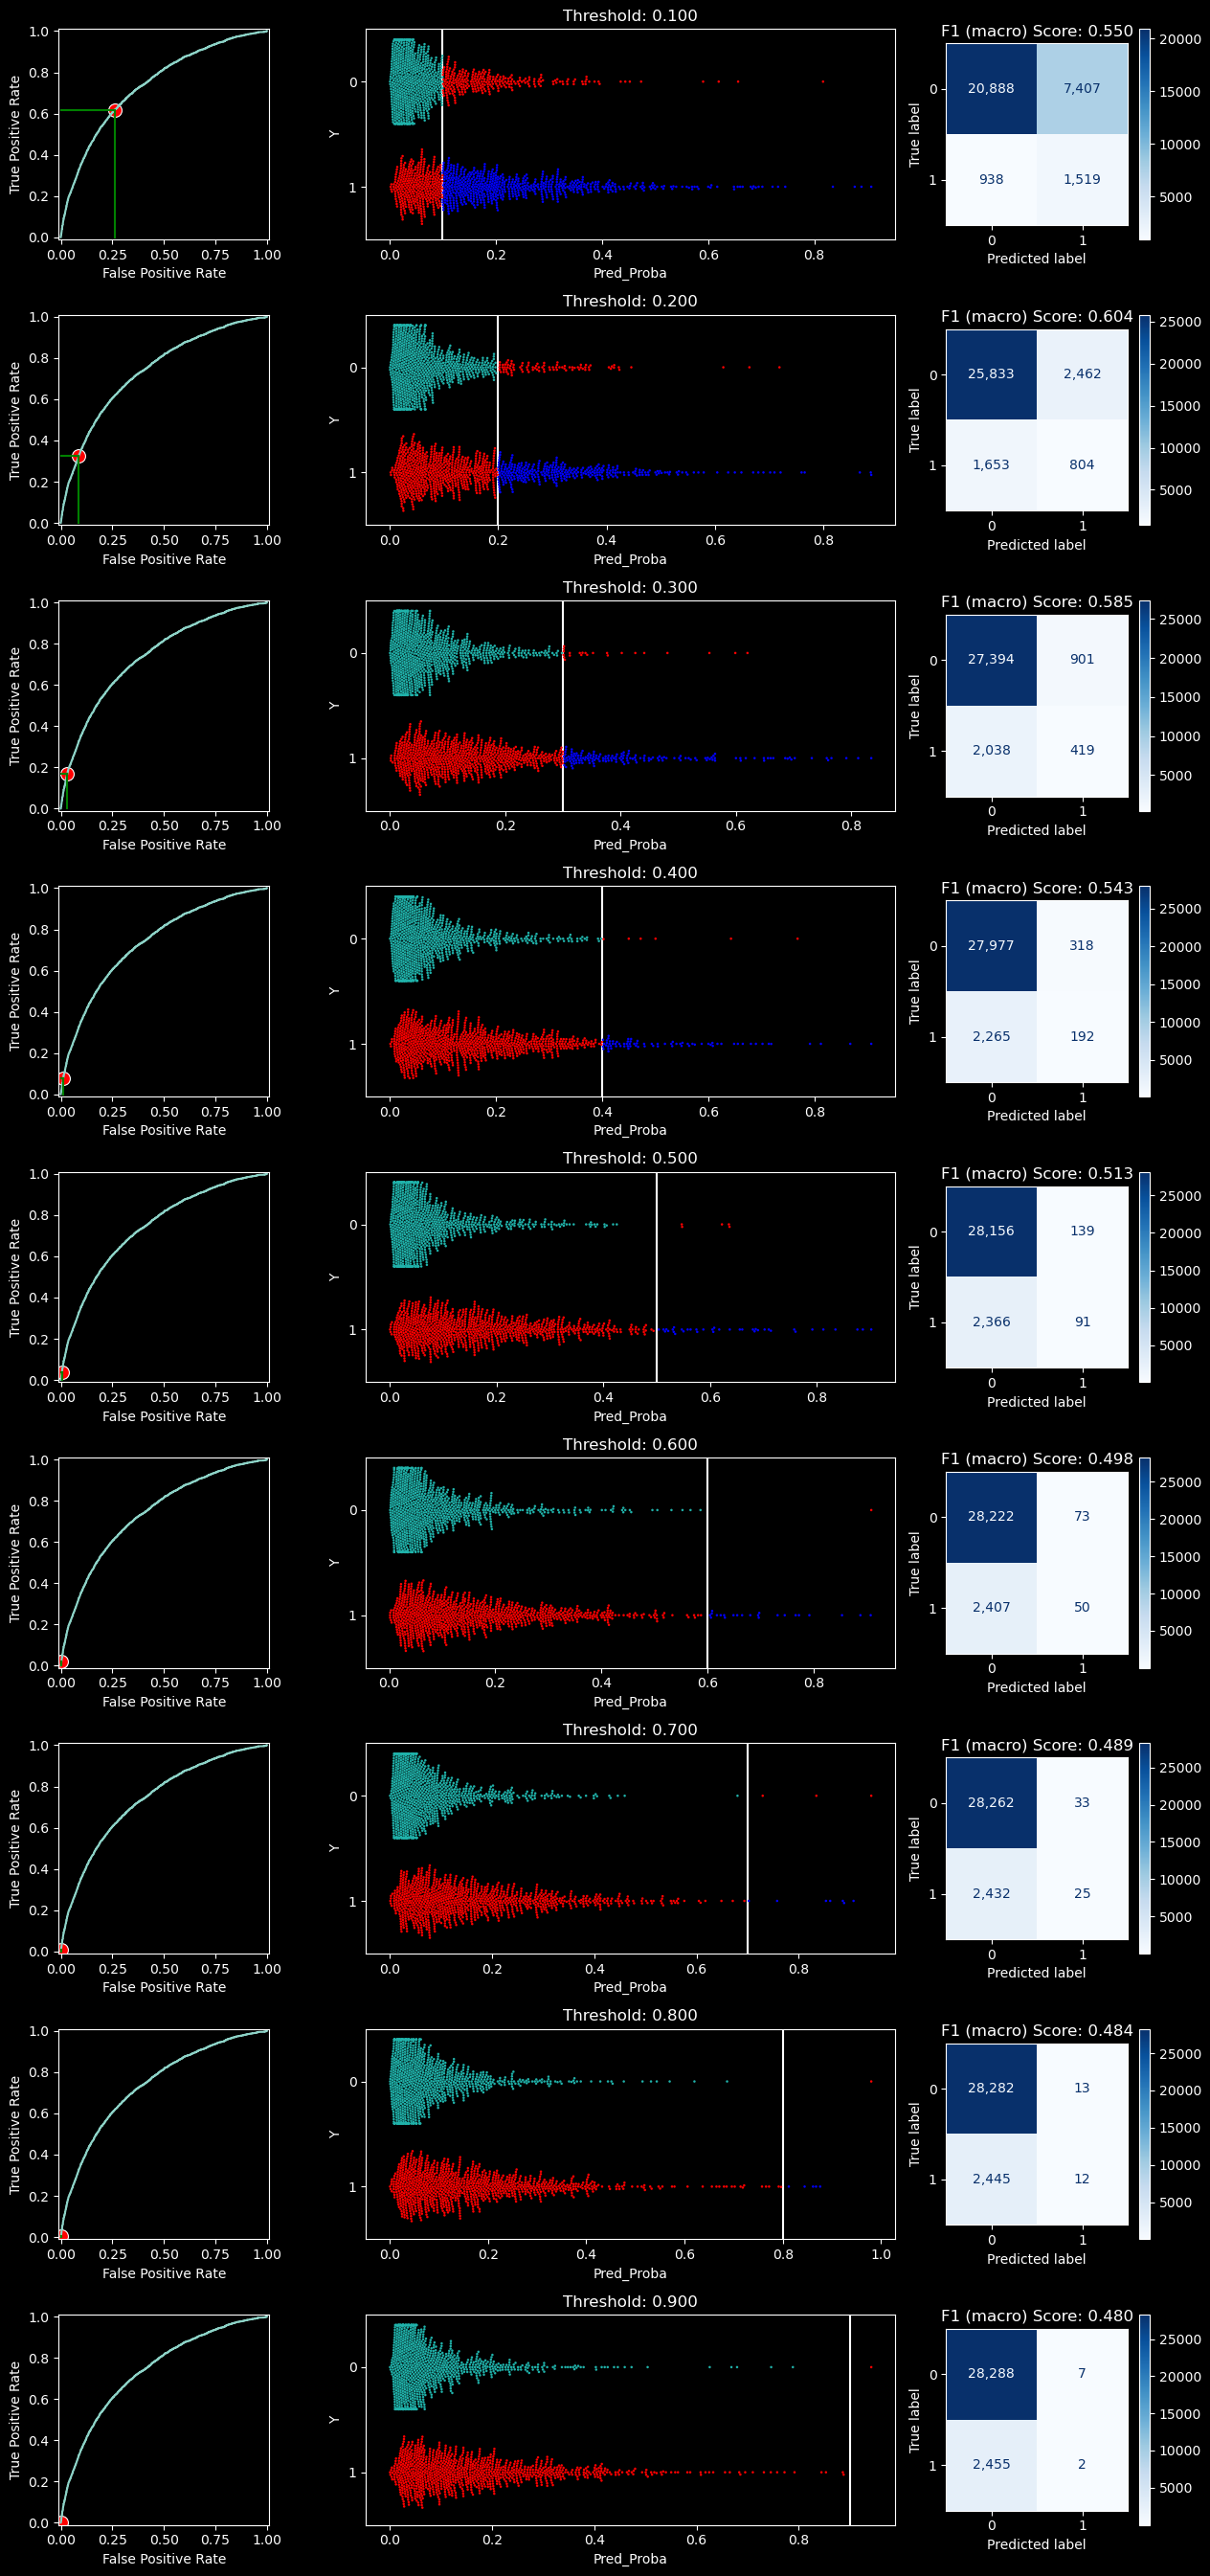

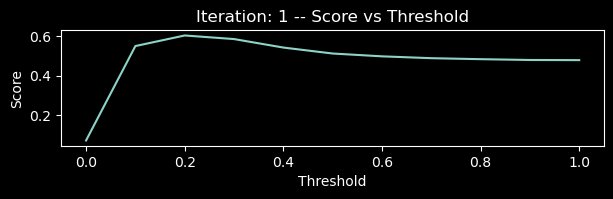

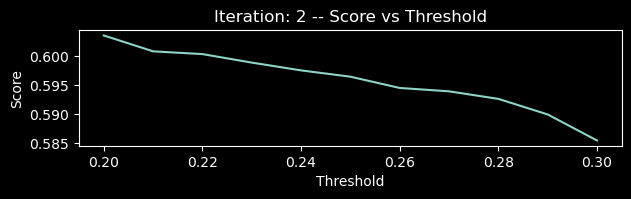

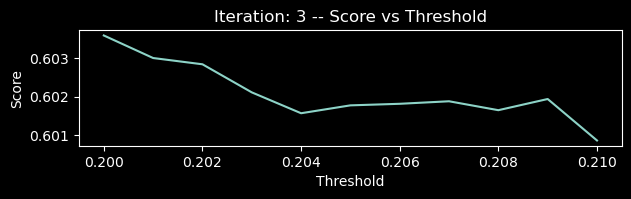

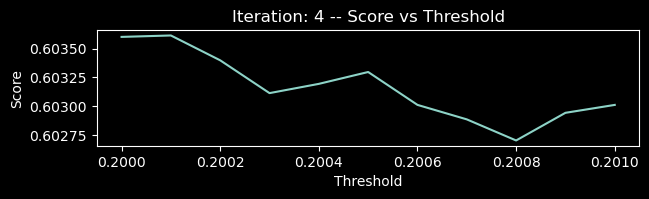

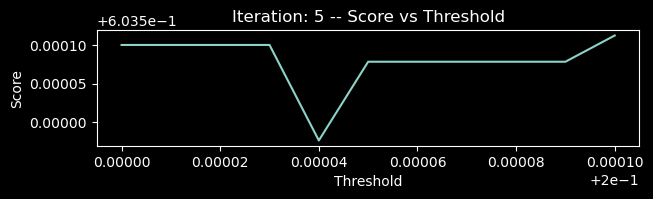

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     28295
           1       0.25      0.33      0.28      2457

    accuracy                           0.87     30752
   macro avg       0.59      0.62      0.60     30752
weighted avg       0.88      0.87      0.87     30752



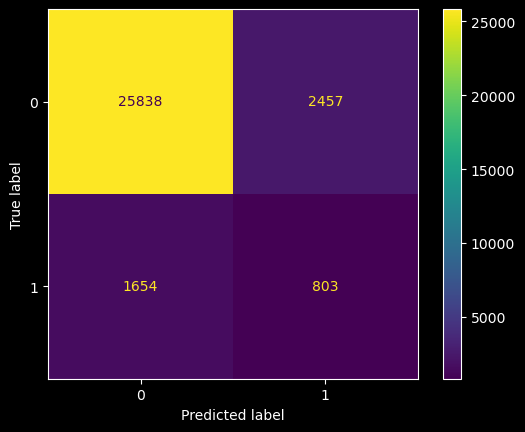

In [108]:
tuner_3 = ClassificationThresholdTuner()

tuner_3.print_stats_table(
    y_true=y_test, 
    target_classes=[0,1],
    y_pred_proba=y_pred_proba,
    num_ranges=len(y_test)
)

tuner_3.print_stats_proba(
    y_true=y_test, 
    target_classes=[0,1], 
    y_pred_proba=y_pred_proba) 

tuner_3.plot_by_threshold(
    y_true=y_test, 
    target_classes=[0,1],
    y_pred_proba=y_pred_proba)

best_threshold_3 = tuner_3.tune_threshold(
    y_true=y_test, 
    target_classes=[0,1],
    y_pred_proba=y_pred_proba,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    max_iterations=5
)

tuned_pred_3 = tuner_3.get_predictions(
    target_classes=[0, 1],
    y_pred_proba=y_pred_proba,
    default_class=0,
    thresholds=best_threshold_3,
)
tuned_pred_3 = pd.Series(tuned_pred_3)
tuned_pred_3 = tuned_pred_3.astype(int)

print(classification_report(y_test, tuned_pred_3, zero_division=np.nan, ))
ConfusionMatrixDisplay.from_predictions(y_test, tuned_pred_3)